In [1]:
!pip install --upgrade pip
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install flax
!pip install optax
!pip install orbax

^C
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
    --------------------------------------- 0.0/2.1 MB 435.7 kB/s eta 0:00:05
   - -------------------------------------- 0.1/2.1 MB 651.6 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/2.1 MB 847.9 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/2.1 MB 1.1 MB/s eta 0:00:02
   ----- ---------------------------------- 0.3/2.1 MB 1.1 MB/s eta 0:00:02
   ------ --------------------------------- 0.4/2.1 MB 1.2 MB/s eta 0:00:02
   -------- ------------------------------- 0.4/2.1 MB 1.2 MB/s eta 0:00:02
   --------- ------------------------------ 0.5/2.1 MB 1.2 MB/s eta 0:00:02
   ---------- ----------------------------- 0.6/2.1 MB 1.3 MB/s eta 0:00:02
   ------------ --------------------------- 0.6/2.1 MB 1.3 MB/s eta 0:00:02
   ------------- -------

ERROR: To modify pip, please run the following command:
D:\Documents\AIExperiments\venv\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


The quality of sinthetic data is paramount to that of the trained model.

In [1]:
import numpy as np
import scipy
from scipy import interpolate, constants, stats
import matplotlib.pyplot as plt
import math
import time
from pathlib import Path
import jax
from jax import vmap, jit
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import orbax.checkpoint as ocp

Make sure to set the following configurations correctly.

In [2]:
DATA_PATH = Path("../data")
CKPT_PATH = Path("/checkpoints")

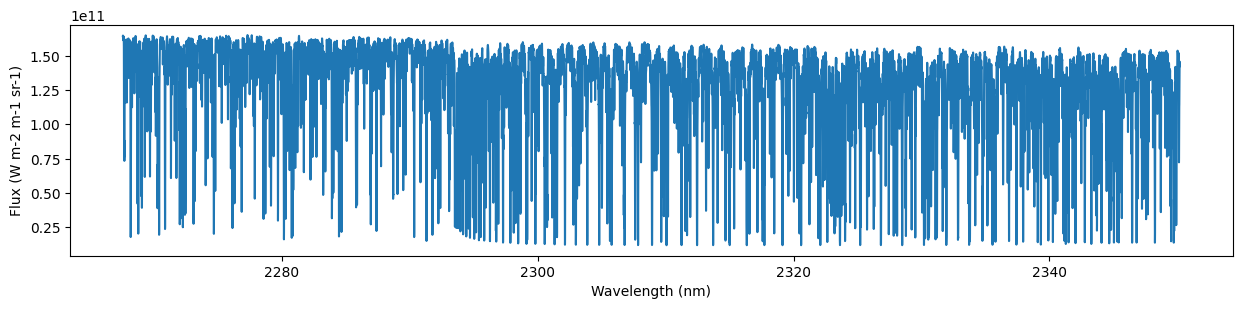

In [3]:
wMod = jnp.load(DATA_PATH / "wmod.npy")
fMod = jnp.load(DATA_PATH / "fmod.npy")

plt.figure(figsize=(15, 3))
plt.plot(wMod, fMod)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux (W m-2 m-1 sr-1)")
plt.show()

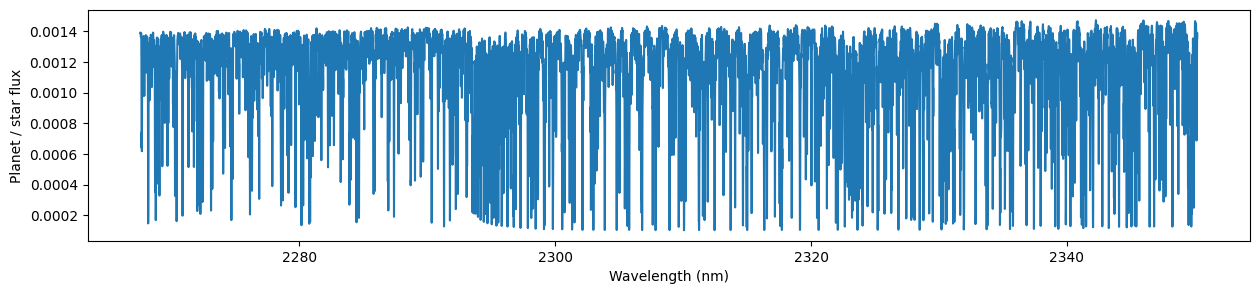

In [ ]:
def blackbody(T,wl):
	h = constants.Planck
	c = constants.speed_of_light
	k = constants.Boltzmann
	c1 = 2.0 * np.pi * h * c * c
	c2 = h * c / k
	val = c2 / wl / T
	return c1 / (wl ** 5.0 * (np.exp(val) - 1.0))

def scale_model(fMod,wlen):
	flux = fMod.copy()
	Rp = 1.38					 # Southworth et al. (2010)
	Rstar = 1.162			 # Torres et al. (2008)
	RR = (Rp * 6.99E7 / (Rstar * 6.957E8)) ** 2.0
	Fstar = np.pi * blackbody(6065.0, wlen * 1E-9)
	flux /= Fstar
	flux *= RR
	return flux

extraScaling = 2
fModScaled = scale_model(fMod*np.pi, wMod) * extraScaling

plt.figure(figsize=(15,3))
plt.plot(wMod, fModScaled)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Planet / star flux")
plt.show()

In [ ]:
def generate_ph(min_ph, max_ph, num=59):
	ph = jnp.linspace(min_ph, max_ph, num=num)
	return ph

## NOTE: These parameters are for the exoplanet HD 209458 b and they are tuned to real CRIRES observations
## of this object under realistic conditions. The observing block is about 5 hours long
Kp = 145.9							 # Planet max. RV (km/s)
air = jnp.load(DATA_PATH / "air.npy") # Airmass variation (from real observations)
rvel = jnp.load(DATA_PATH / "rvel.npy") # Systemic + barycentric radial velocity (km/s)
wlen_regr = jnp.load(DATA_PATH / "wlen_regr.npy")
spec = jnp.load(DATA_PATH / "algn.npy")

The following functions create and visualize a sinthetic planetary signal given the relevant parameters.

The planet emits a spectrum which depends on the composition of its atmosphere. As it follows its cirular orbit around the star, its velocity relative to the Earth changes and so does the shift of its spectrum due to the Doppler effect.

Each image shown corresponds to an order. The vertical axis represents time and orbital phase (which correlate linearly). The horizontal axis corresponds to wavelengths and thus covers different values for each order. The lines of the planetary signal are tilted and somewhat curved due to the varying velocity of the planet.

2024-04-14 04:12:40.202622: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


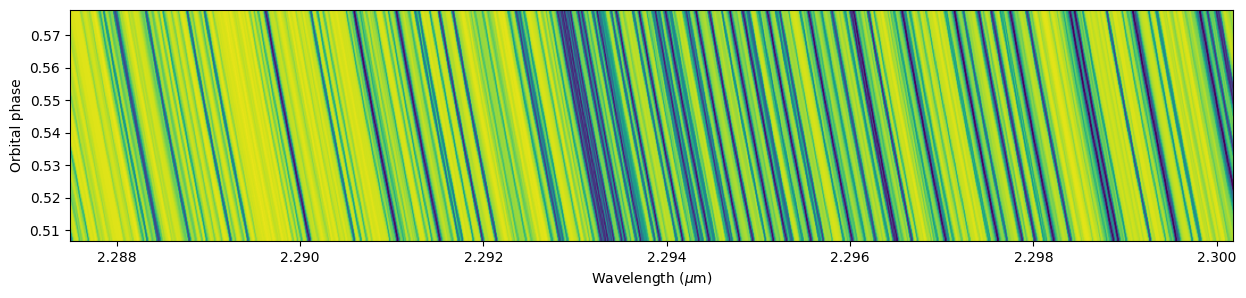

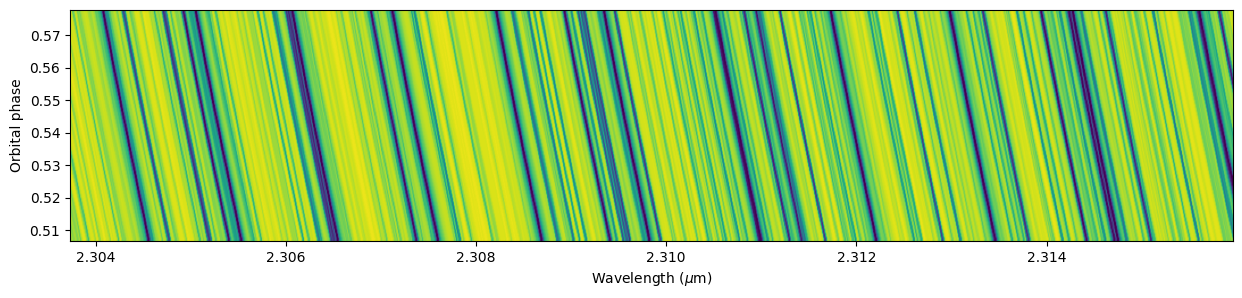

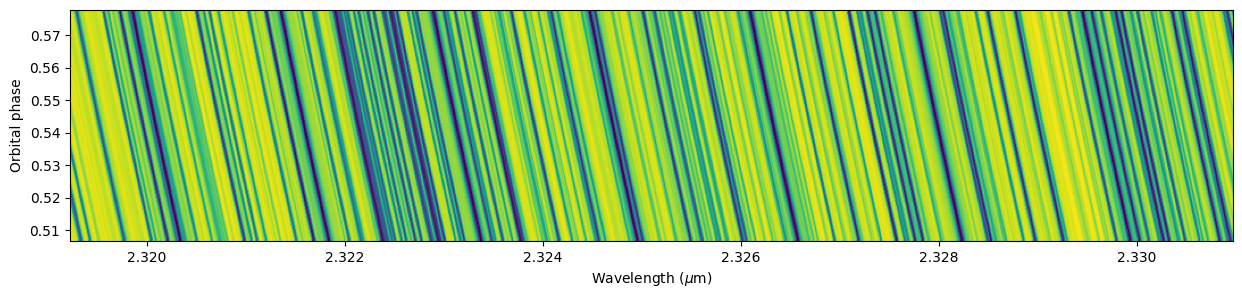

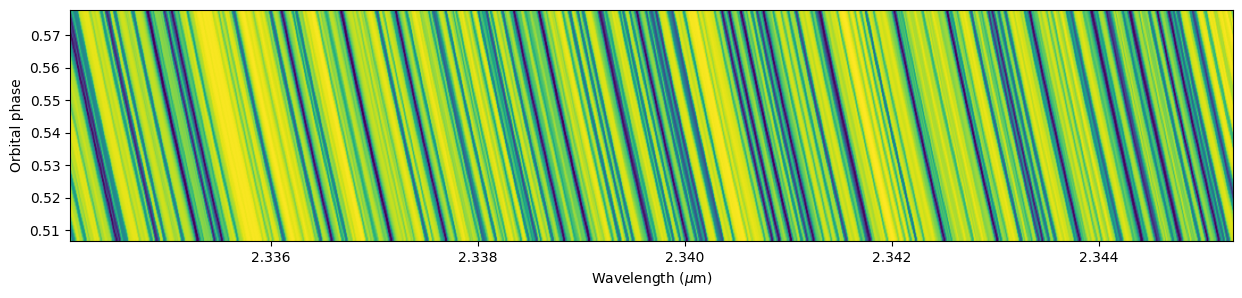

0

In [ ]:
def create_planet_signal(wMod, fMod1, ph, rvel, Kp):
	no, nf, nx = spec.shape
	Vpl = rvel + Kp * np.sin(2.0 * np.pi * ph)
	cs = interpolate.splrep(wMod, fMod1, s=0)
	spcFake = np.ones((no, nf, nx))
	c = constants.speed_of_light
	for io in range(no):
		for j in range(nf):
			wMod1 = wlen_regr[io] * (1.0 - Vpl[j] * 1000 / c)	# Doppler effect
			spcFake[io, j] += interpolate.splev(wMod1, cs, der=0)
	wlen_regr_conv = np.asarray(wlen_regr, dtype=np.float32)
	spcFake_conv = np.asarray(spcFake, dtype=np.float32)
	return wlen_regr_conv, spcFake_conv

def plot_matrix(wlen, mat, ph):
	no, nf, nx = mat.shape
	v0 = mat.min()
	v1 = mat.max()
	for io in range(no):
		plt.figure(figsize=(15, 3))
		lims = [wlen[io, 0] / 1E3, wlen[io, -1] / 1E3, ph[0], ph[-1]]
		plt.imshow(mat[io], origin="lower", extent=lims, aspect="auto", vmin=v0, vmax=v1)
		plt.xlabel("Wavelength ($\mu$m)")
		plt.ylabel("Orbital phase")
		plt.show()
	return 0

ph = generate_ph(0.50673796, 0.57780502)	 # Orbital phases (from real observations) (tr)
wFake, spcFake = create_planet_signal(wMod, fModScaled, ph, rvel, Kp)
plot_matrix(wFake, spcFake, ph)

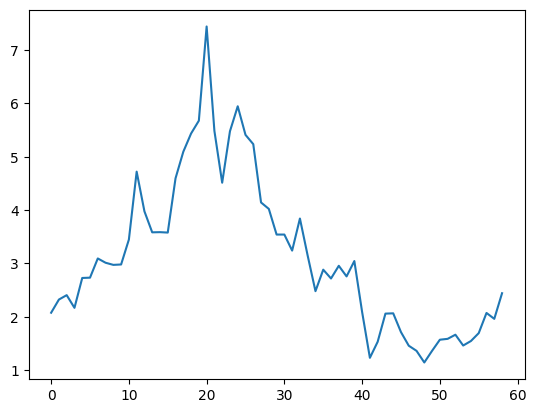

In [ ]:
def random_process(size, p):
	random = np.random.normal(size=size)
	v = random[0] / np.sqrt(1 - p ** 2)
	sequence = [v]
	for r in random[1:]:
		v = v * p + r
		sequence.append(v)
	sequence = jnp.asarray(sequence)
	sequence *= jnp.sqrt(1 - p ** 2)
	return sequence

def random_pwv(size, dt=1, pace=1e4, sigma=0.667, scale=3.294):
	pace /= dt
	p = pace / (pace + 1)
	sequence = random_process(size, p)
	sequence *= sigma
	pwv = jnp.exp(sequence)
	pwv *= scale
	return pwv

timespan = 5 * 60 * 60

pwv = random_pwv(59, dt=timespan / 59)

plt.plot(pwv)
plt.show()

(4, 59, 1024)


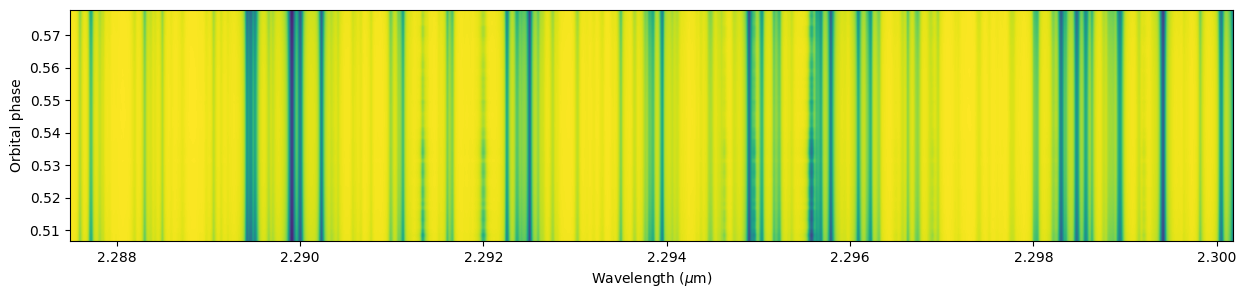

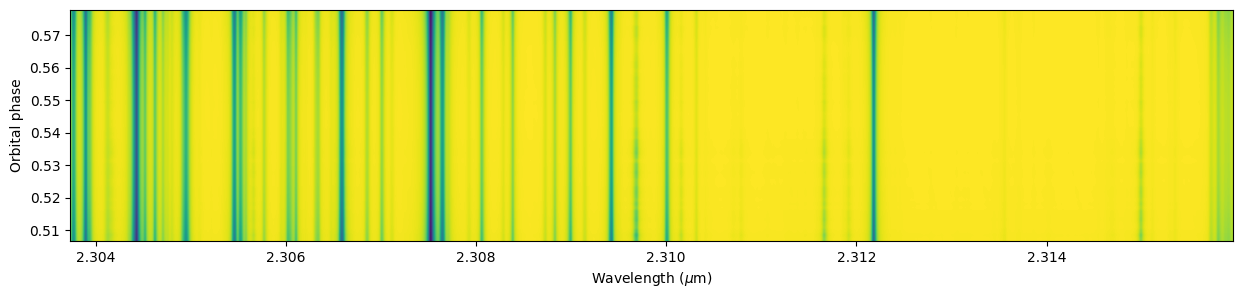

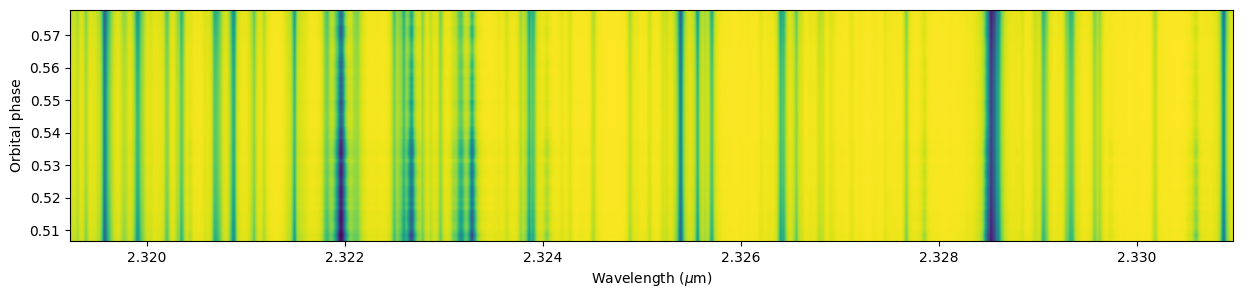

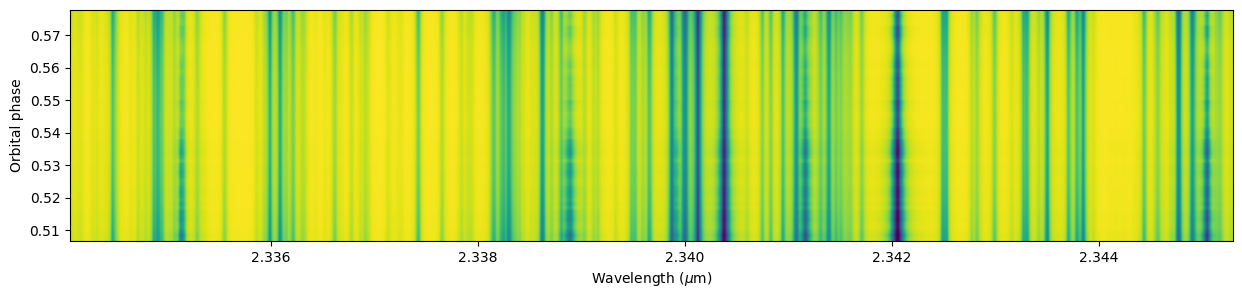

0

In [ ]:
def get_gaussian_ip(res, wl): # Gaussian instrumental profile.
	lamPix = (wl[1:] + wl[:-1]) / 2
	dlamPix = wl[1:] - wl[:-1]
	dvPix = np.mean(dlamPix / lamPix)
	dvFWHM = 1 / res
	fwhmPix = dvFWHM / dvPix
	sigmaPix = 0.5 * fwhmPix / np.sqrt(2 * np.log(2))
	hker = int(4 * fwhmPix)
	xker = np.arange(-hker, hker + 1)
	yker = np.exp(-0.5 * (xker / sigmaPix) ** 2)
	yker /= yker.sum()
	return yker, hker

def get_telluric_spectrum(air0, pwv0, coeffFit):
	pwvFitLog = np.linalg.multi_dot((np.stack((pwv0, np.ones(pwv0.size)), axis=1), coeffFit)) #np.array([pwv0, 1]) @ coeffFit  # Right PWV, airmass = 1
	telFitLog = pwvFitLog * air0[:, None]
	telFit = np.exp(telFitLog)
	return telFit

def broaden_spectrum(flux, wlen):
	ker, hk = get_gaussian_ip(100000, wlen)
	fluxBroad = scipy.signal.convolve2d(flux, ker[None], mode="valid")
	return wlen[hk : -hk], fluxBroad

telGrid = jnp.load(DATA_PATH / "trGrid_crires.npy")
telGrid[telGrid == 0] = 1E-20

_, nxx = telGrid.shape

wl0 = 2200
wlGrid = np.exp(4e-6 * np.arange(nxx) + np.log(wl0))

assert wlGrid.min() > 1000

pwv_values = np.asarray([0.5, 1.0, 1.5, 2.5, 3.5, 5.0, 7.5, 10.0, 20.0])

grid = np.log(telGrid)

coeffFit = np.polyfit(pwv_values, grid, 1)

timespan = 5 * 60 * 60

def generate_tell():
    pwv_sequence = random_pwv(air.size, dt=timespan / air.size)
    telSpecModelR = get_telluric_spectrum(air, pwv_sequence, coeffFit)
    wlClipped, telSpecInstrumentR = broaden_spectrum(telSpecModelR, wlGrid)
    tell = jnp.stack([interpolate.splev(wlen_regr, interpolate.splrep(wlClipped, telSpec)) for telSpec in telSpecInstrumentR], axis=1)
    return tell

tell = generate_tell()

print(tell.shape)
pureSignal = spcFake * tell
plot_matrix(wFake, pureSignal, ph)

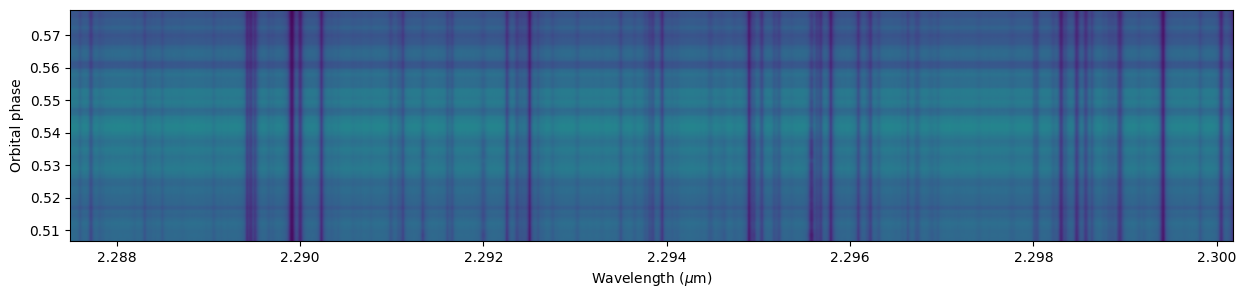

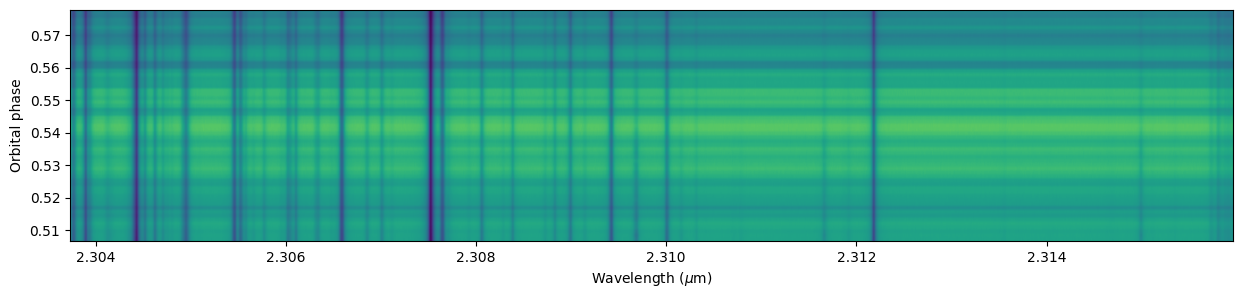

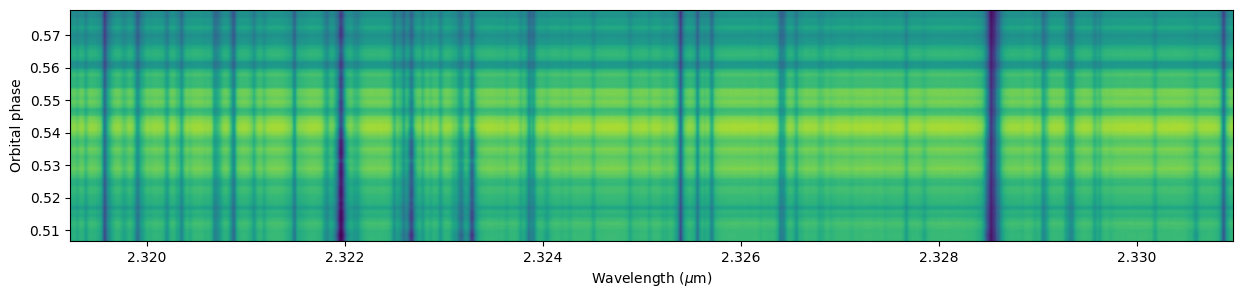

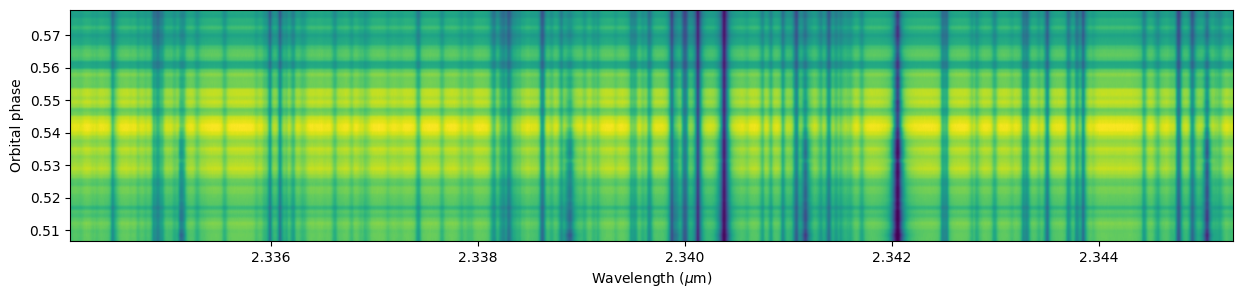

0

In [ ]:
@jit
def add_noise(key, spcFake):
		expTime = 150.0 * 2.0			 # Twice the actual exposure time
		detGain = jnp.asarray([6.97, 6.89, 6.92, 7.27])
		spcNorm = expTime * detGain[:, None, None] * spec	 # Counts -> e-
		vsort = jnp.sort(spcNorm)
		cnt = (vsort[..., 856] + vsort[..., 857]) / 2	 # Median counts per spec
		spcFake *= cnt[..., None]
		# Adding Gaussian noise
		phNoiseAmp = jnp.sqrt(spcFake)
		noise = jax.random.normal(key, shape=spcFake.shape)
		noise *= phNoiseAmp
		spcFake += noise
		spcFake /= (expTime * detGain[:, None, None])
		return spcFake

key = jax.random.PRNGKey(44)

key, noise_key = jax.random.split(key)

signal = add_noise(noise_key, pureSignal)
plot_matrix(wFake, signal, ph)

The `gen_spectrum` function below generates a synthetic observation.

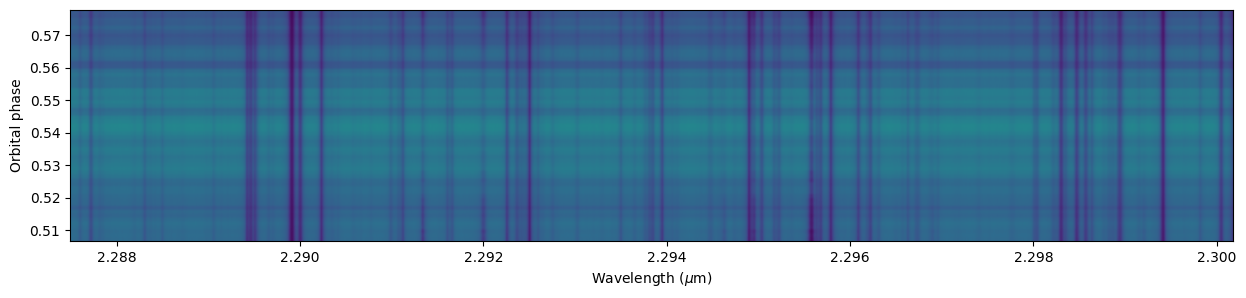

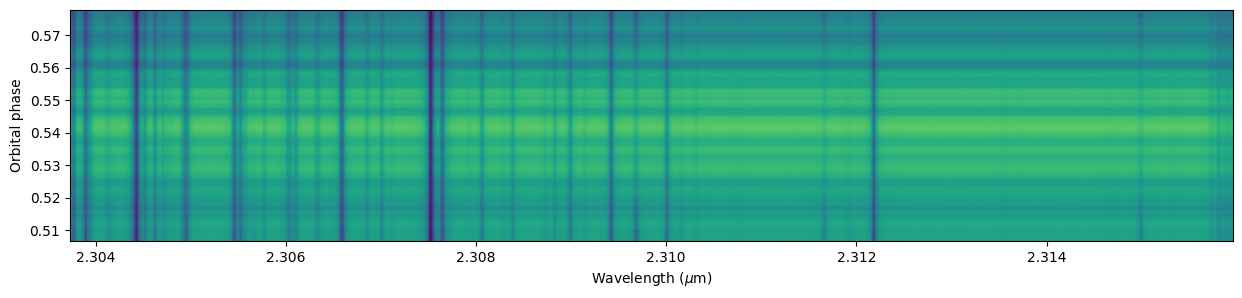

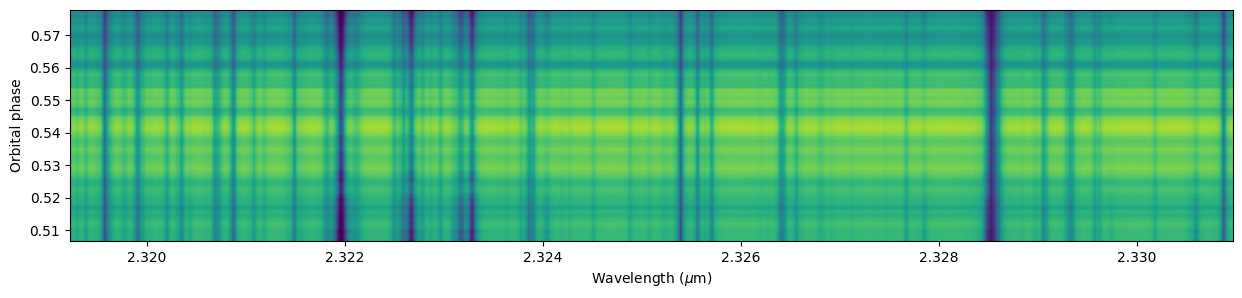

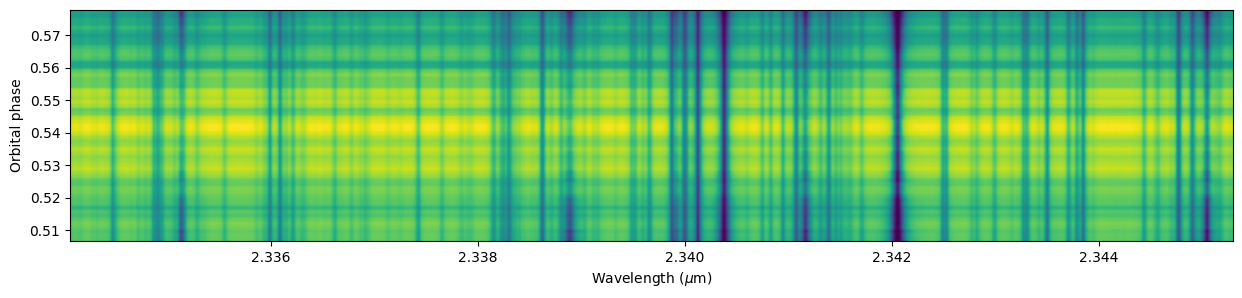

0

In [ ]:
ph_offset = 0.07106706
ph_0_min = 0.35
ph_0_max = 0.65

fModScaled = scale_model(fMod * np.pi, wMod) * extraScaling

def random_planet_sequence(key):
	ph_0_key, ph_select_key = jax.random.split(key)
	ph_0 = jax.random.uniform(ph_0_key, minval=ph_0_min, maxval=ph_0_max - ph_offset)
	ph1 = generate_ph(ph_0, ph_0 + ph_offset)
	ph2 = jnp.flip(ph1)
	seq_choice = jax.random.choice(ph_select_key, 2)
	ph = jax.lax.select(seq_choice, ph1, ph2)
	return create_planet_signal(wMod, fModScaled, ph, rvel, Kp)

def random_sequences(key):
	sequences = []
	for i in range(50):
		key, ph_key = jax.random.split(key)
		_, sequence = random_planet_sequence(ph_key)
		sequences.append(sequence)
	sequences = jnp.asarray(sequences)
	return sequences

def random_tells(key):
	tells = []
	for i in range(20):
		tell = generate_tell()
		tells.append(tell)
	tells = jnp.asarray(tells)
	return tells

@jit
def gen_spectrum(key, planet, sequences, tells):
	ph_key, tell_key, noise_key = jax.random.split(key, num=3)
	extraScaling = 2

	seq_choice = jax.random.choice(ph_key, 50)
	spcFake = sequences[seq_choice]
	tell_choice = jax.random.choice(tell_key, 50)
	tell = tells[tell_choice]
	ones = jnp.ones(spcFake.shape)

	spcFake = jax.lax.select(planet, spcFake, ones)

	pureSignal = spcFake * tell

	signal = add_noise(noise_key, pureSignal)
	return signal, spcFake

key, sequences_key, tells_key, signal_key = jax.random.split(key, num=4)

sequences = random_sequences(sequences_key)
tells = random_tells(tells_key)

signal, _ = gen_spectrum(key, True, sequences, tells)
plot_matrix(wFake, signal, ph)

In [ ]:
gen_spectra = vmap(gen_spectrum, in_axes=(0, None, None, None))

def normalize_spectrum(spectrum):
	std = spectrum.std()
	mean = spectrum.mean()
	spectrum = (spectrum - mean) / std
	return spectrum

normalize_spectra = vmap(normalize_spectrum)

def gen_batch(key, num_spectra, sequences, tells):
	keys = jax.random.split(key, num=num_spectra)
	neg_x, neg_y = gen_spectra(keys, False, sequences, tells)
	neg_x = neg_x.reshape((-1, *neg_x.shape[2:], 1))
	neg_y = neg_y.reshape((-1, *neg_y.shape[2:], 1))
	neg_y = np.zeros(neg_y.shape)
	pos_x, pos_y = gen_spectra(keys, True, sequences, tells)
	pos_x = pos_x.reshape((-1, *pos_x.shape[2:], 1))
	pos_y = pos_y.reshape((-1, *pos_y.shape[2:], 1))
	pos_y = normalize_spectra(pos_y)
	x = jnp.concatenate((neg_x, pos_x))
	x = normalize_spectra(x)
	y = jnp.concatenate((neg_y, pos_y))
	return x, y

In [ ]:
@jit
def train_step(state, batch):
	x, y = batch
	def loss_fn(params):
		preds = state.apply_fn({ "params": params }, x)
		loss = optax.l2_loss(preds, targets=y).mean()
		return loss
	grad_fn = jax.value_and_grad(loss_fn)
	loss, grads = grad_fn(state.params)
	state = state.apply_gradients(grads=grads)
	return state, loss

def create_train_state(module, rng, learning_rate, momentum):
	params = module.init(rng, signal.reshape(*signal.shape, 1))["params"]
	tx = optax.adam(learning_rate)
	return train_state.TrainState.create(apply_fn=module.apply, params=params, tx=tx)

In [ ]:
class Cross(nn.Module):
	h_features: int
	w_features: int

	@nn.compact
	def __call__(self, x):
		h = x.shape[1]
		w = x.shape[2]
		a = nn.Conv(features=self.h_features, kernel_size=(h, 1), padding="VALID")(x)
		b = nn.Conv(features=self.w_features, kernel_size=(1, w), padding="VALID")(x)
		a = jnp.repeat(a, h, axis=1)
		b = jnp.repeat(b, w, axis=2)
		x = jnp.concatenate((a, b), axis=-1)
		return x

Here we declare the neural architecture which will be used.

Each sample in input to the neural network will represent an individual order of an observation. The corresponding output is an approximated prediction of the clean planetary signal. An extra dimension, representing the depth of these images, is added, but the number of channels is only one.

The actual tensor received (and produced) by the neural network represents a batch of samples. The input and output tensor will have the same shape: `(batch_size, phase, waveLenght, 1)`.

The neural network contains ordinary convolutional layers, which also pad the tensor so as not to reduce its size, as well as *cross* layers. ReLU is used as the activation function of hidden layers. The output of each cross layers is combined back with its own input, resulting in a deeper tensor. This is done in order to preserve information about the individual pixel. The result is a tensor which still contains duplicated data along each row and column (due to the *cross* layer). Passing this directly to a convolutional layer with a large kernel would result in operations on duplicated data. To address this, the network uses $1 \times 1$ convolutional layers which reduce the depth of the tensor.

In [ ]:
class CNN(nn.Module):
	@nn.compact
	def __call__(self, x):
		ones = jnp.ones(x.shape)
		x = jnp.concatenate((x, ones), axis=-1)
		x = nn.Conv(features=64, kernel_size=(11, 11), use_bias=False)(x)
		x = nn.leaky_relu(x)
		cross = Cross(64, 64)(x)
		cross = nn.leaky_relu(cross)
		x = jnp.concatenate((cross, x), axis=-1)
		x = nn.Conv(features=64, kernel_size=(1, 1))(x)
		residual = x
		x = nn.leaky_relu(x)
		x = nn.Conv(features=64, kernel_size=(11, 11))(x)
		x = nn.leaky_relu(x)
		cross = Cross(64, 64)(x)
		cross = nn.leaky_relu(cross)
		x = jnp.concatenate((cross, x), axis=-1)
		x = nn.Conv(features=64, kernel_size=(1, 1))(x)
		x = x + residual
		x = nn.leaky_relu(x)
		x = nn.Conv(features=64, kernel_size=(11, 11))(x)
		x = nn.leaky_relu(x)
		cross = Cross(64, 64)(x)
		cross = nn.leaky_relu(cross)
		x = jnp.concatenate((cross, x), axis=-1)
		x = nn.Conv(features=64, kernel_size=(1, 1))(x)
		x = nn.leaky_relu(x)
		x = nn.Conv(features=1, kernel_size=(11, 11))(x)
		return x

In [ ]:
learning_rate = 0.00001
momentum = 0.9
num_spectra = 4

key, init_key = jax.random.split(key)

jax.config.update("jax_debug_nans", True)

cnn = CNN()
state = create_train_state(cnn, init_key, learning_rate, momentum)

options = ocp.CheckpointManagerOptions(max_to_keep=20)
mngr = ocp.CheckpointManager(CKPT_DIR, options=options)

epoch = 0

In [ ]:
start_total_time = time.time()

key, seq_key, tells_key = jax.random.split(key, num=3)
sequences = random_sequences(seq_key)
tells = random_tells(tells_key)

prev_epoch_loss = math.inf

while True:
	mngr.save(epoch, args=ocp.args.StandardSave(state))
	epoch_loss = 0
	start_epoch_time = time.time()
	for _ in range(100):
		key, batch_key = jax.random.split(key)
		batch = gen_batch(batch_key, num_spectra, sequences, tells)
		state, loss = train_step(state, batch)
		epoch_loss += loss
	if epoch % 10 == 0:
		mngr.wait_until_finished()
	epoch_loss /= 100
	epoch_time = time.time() - start_epoch_time
	total_time = time.time() - start_total_time
	print(epoch, "-", epoch_loss, "-", epoch_time, "-", total_time)
	if epoch % 25 == 0:
		key, seq_key, tells_key = jax.random.split(key, num=3)
		sequences = random_sequences(seq_key)
		tells = random_tells(tells_key)
	if epoch_loss > prev_epoch_loss * 1.25 or (epoch > 100 and epoch_loss > 0.24):
		print("Restoring checkpoint", epoch - 5)
		state = mngr.restore(epoch - 5, args=ocp.args.StandardRestore(state))
		learning_rate /= 2
		print("New learning rate:", learning_rate)
		tx = optax.adam(learning_rate)
		state = train_state.TrainState.create(apply_fn=state.apply_fn, params=state.params, tx=tx)
	prev_epoch_loss = epoch_loss
	epoch += 1

2024-04-14 04:16:44.256470: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,59,1024]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,59,1024]{3,2,1,0}, f32[64,64,11,11]{3,2,1,0}, f32[64]{0}), window={size=11x11 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-04-14 04:16:44.498428: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.242242416s
Trying algorithm eng0{} for conv (f32[32,64,59,1024]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,59,1024]{3,2,1,0}, f32[64,64,11,11]{3,2,1,0}, f32[64]{0}), window={size=11x11 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

0 - 0.24978213 - 98.13470482826233 - 114.78615283966064
1 - 0.24877414 - 41.231606006622314 - 170.45436906814575
2 - 0.24794923 - 41.36982202529907 - 212.02202987670898
3 - 0.24729021 - 41.01061010360718 - 253.1833782196045
4 - 0.24691842 - 40.62516474723816 - 294.1257870197296
5 - 0.24647067 - 41.094013690948486 - 335.3609576225281
6 - 0.24626312 - 41.35388684272766 - 376.85217547416687
7 - 0.2460661 - 41.20232272148132 - 418.1964783668518
8 - 0.24586442 - 40.99353742599487 - 459.3337092399597
9 - 0.24573146 - 41.40505361557007 - 500.87593698501587
10 - 0.24565667 - 41.48864674568176 - 542.5047414302826
11 - 0.24541353 - 41.10838484764099 - 583.7534515857697
12 - 0.24533704 - 41.34747529029846 - 625.2372751235962
13 - 0.24508624 - 41.39276456832886 - 666.770833492279
14 - 0.2450991 - 41.25413799285889 - 708.1720690727234
15 - 0.24488994 - 41.21419930458069 - 749.528507232666
16 - 0.24486832 - 41.286741971969604 - 790.9545991420746
17 - 0.2448745 - 41.300135135650635 - 832.399717092514

In [ ]:
key, _ = jax.random.split(key)

spectrum, _ = gen_spectrum(key, False, sequences, tells)
spectrum = spectrum.reshape((*spectrum.shape, 1))
spectrum = normalize_spectra(spectrum)
pred1 = cnn.apply({ "params": state.params }, spectrum)
pred1 = pred1.reshape(pred1.shape[:-1])

spectrum, sign = gen_spectrum(key, True, sequences, tells)
spectrum = spectrum.reshape((*spectrum.shape, 1))
spectrum = normalize_spectra(spectrum)
pred2 = cnn.apply({ "params": state.params }, spectrum)
pred2 = pred2.reshape(pred2.shape[:-1])

spectrum = spectrum.reshape(spectrum.shape[:-1])

pred = pred2 - pred1

plot_matrix(wFake, pred2, ph)

print(pred1.std())
print(pred2.std())